In [1]:
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import requests
import re

In [2]:
import matplotlib.pyplot as plt
import math
import seaborn as sns

In [3]:
from sqlalchemy import create_engine
import logging
from sqlalchemy.orm import declarative_base
from sqlalchemy import Column, Integer, String
from sqlalchemy.orm import sessionmaker
from sqlalchemy import text

# Data Preprocessing

Running this part will download all the files in the local repo, but it will take a long time. 
Depending on the machine it runs on, it might throw error due to large size.

### Clean Weather Data

All weather csv are cleaned and seperated into hours part and days part

In [ ]:
#create the clean version of weather csv and seprated into two parts
def create_weather_csv(filename):
    # make sure the output title is consistent 
    title1 = ""
    title2 = ""
    m = re.search(r'(\d+_weather)', filename)
    if m:
        title1 = m.group(1) + '_hours.csv'
        title2 = m.group(1) + '_days.csv'
    
    
    #this function cleans the weather csv and output 2 csv, one is for daily and one is for hour
    df = pd.read_csv(filename,usecols=['DATE','HourlyWindSpeed','HourlyPrecipitation'])
    #deal with missing value and special character
    df = df.fillna(0)
    df = df.replace('T',0)
    df = df.replace('s','',regex = True)
    #change the data type
    df.DATE = pd.to_datetime(df.DATE)
    df = df.astype({'HourlyPrecipitation':float,'HourlyWindSpeed':float})
    df.set_index('DATE',drop = True).to_csv(title1)
    df = df.resample('D', on='DATE').mean() 
    df = df.rename(mapper = {"HourlyPrecipitation":"DailyPrecipitation", "HourlyWindSpeed":"DailyWindSpeed"},axis = 1)
    df.to_csv(title2)
    
    

In [ ]:
for i in range(2009,2016):
    #create all weather data from 2009 to 2015
    filename = str(i)+"_weather.csv"
    create_weather_csv(filename)

### Clean Uber Data

Clean uber sample data and makes the name consistent to the yellow taxi data

In [ ]:
uber = pd.read_csv('uber_rides_sample.csv')

In [ ]:
#this function gets the distance between two coordinates
def get_distance(lon1,lat1,lon2,lat2):
    from math import sin, cos, sqrt, atan2, radians
    R = 6373
    lon1 = radians(lon1)
    lat1 = radians(lat1)
    lon2 = radians(lon2)
    lat2 = radians(lat2)
    
    dlon = lon1 - lon2
    dlat = lat1 - lat2
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    
    distance = R * c
    return distance

In [ ]:
#add distance to the dataframe with coordinates
def add_distance(df):
    distance = []
    lon1 = list(df['pickup_longitude'])
    lon2 = list(df['dropoff_longitude'])
    lat1 = list(df['pickup_latitude'])
    lat2 = list(df['dropoff_latitude'])
    for i in range(len(lon1)):
        distance.append(get_distance(lon1[i],lat1[i],lon2[i],lat2[i]))
    df['distance']  = distance

In [ ]:
#create the clean version of uber dataframe
def create_uber(df):
    #clean uber data
    df = df.rename(columns = lambda x: x.strip())
   
    #drop and rename column
    to_drop = [
        "Unnamed: 0",
        "key",
        "passenger_count"
    ]
    
    mapper = {
        "pickup_datetime" :"pickup_time",
        "fare_amount" : "charge"
    }
    df = df.drop(to_drop, axis = 1,errors = "ignore")
    df = df.rename(mapper, axis = 1)
    df.dropna(inplace = True)
    
    #modify datatype
    df = df.astype({"pickup_time":np.datetime64})
    
    
    #add distance
    add_distance(df)
    df.to_csv('uber.csv',index = False)

In [ ]:
create_uber(uber)

### Clean Yellow Taxi Data

find all csv files and filter them, then download as a dataframe and clean the data

In [ ]:
def get_csv_links():
    #this function visits： https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page
    #It requests the source code on the website and get all the hrefs related to csv
    #the urls are saved in link_lists
    link_lists = []
    url = "https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page"
    page = requests.get(url)
    soup = BeautifulSoup(page.text, 'html.parser')
    aclasses = soup.find_all('a')
    for a in aclasses:
        link_lists.append(a.get('href'))
    #Then we filter on link_lists using re because we only want to grab csv for yellow taxi ranging from 2009 - 2015.
    csv_links = []
    pattern = re.compile(r'.yellow_tripdata_(200[9]|201[0-5])-\d\d\.csv$')
    for i in link_lists:
        if re.search(pattern,i):
            csv_links.append(i)
    return csv_links
    

In [ ]:
westlimit=-74.242330; southlimit=40.560445; eastlimit=-73.717047; northlimit=40.908524
#Remove the data that is not within the limits specified above

def fix_longitude(input_longitude):
    try:
        input_longitude = float(input_longitude)
    except:
        return np.NaN
    if input_longitude < westlimit or input_longitude > eastlimit:
        return np.NaN
    return input_longitude


def fix_latitude(input_latitude):
    try:
        input_latitude = float(input_latitude)
    except:
        return np.NaN
    if input_latitude < southlimit or input_latitude > northlimit:
        return np.NaN
    return input_latitude


def fix_df(df):
    df['pickup_longitude']=df['pickup_longitude'].apply(fix_longitude)
    df['dropoff_longitude']=df['dropoff_longitude'].apply(fix_longitude)
    df['pickup_latitude']=df['pickup_latitude'].apply(fix_latitude)
    df['dropoff_latitude']=df['dropoff_latitude'].apply(fix_latitude)
    df.dropna(inplace = True)

In [ ]:
def create_csv(csv_link):
   
    # make sure the output title is consistent 
    title = ""
    m = re.search(r'(yellow.+)', csv_link)
    if m:
        title = m.group(1)
   
    #read the data into a dataframe
    df = pd.read_csv(csv_link,on_bad_lines='skip')
    df = df.rename(columns = lambda x: x.strip())
   
    #drop and rename column
    to_drop = [
        "Unnamed: 0",
        "vendor_name",
        "vendor_id",
        "Vendor_id",
        'VendorID',
        "Trip_distance",
        "Trip_Distance",
        "trip_distance",
        "Rate_Code",
        "store_and_forward",
        "store_and_fwd_flag",
        "Payment_Type",
        "Fare_Amt",
        "surcharge",
        "mta_tax",
        "Tolls_Amt",
        "rate_code",
        "RatecodeID",
        "RateCodeID",
        "payment_type",
        "fare_amount",
        "extra",
        "tolls_amount",
        "improvement_surcharge",
        "Passenger_Count",
        "passenger_count"
    ]
    
    mapper = {
        "Trip_Pickup_DateTime" : "pickup_time",
        "tpep_pickup_datetime" : "pickup_time",
        "pickup_datetime": "pickup_time",
        "dropoff_datetime" : "dropoff_time",
        "Trip_Dropoff_DateTime" : "dropoff_time",
        "tpep_dropoff_datetime" : "dropoff_time",
        "Start_Lon" : "pickup_longitude",
        "Start_Lat" : "pickup_latitude",
        "End_Lon" : "dropoff_longitude",
        "End_Lat" : "dropoff_latitude",
        "Tip_Amt" : 'tip',
        "tip_amount" : "tip",
        "Total_Amt" : "charge",
        "total_amount" : "charge"
    }
    df = df.drop(to_drop, axis = 1,errors = "ignore")
    df = df.rename(mapper, axis = 1)
    df.dropna(inplace = True)
    
    #modify datatype
    df = df.astype({"pickup_time":np.datetime64,"dropoff_time": np.datetime64})
    
    
    #make sure the trip is within(40.560445, -74.242330) and (40.908524, -73.717047)
    fix_df(df)
    
    #sample 3000 rows
    df = df.sample(n=3000)
    
    #add distance
    add_distance(df)
    df.reset_index(inplace = True, drop = True)
    
    df.to_csv(title,index= False)

run this to download all the yellow taxi sample data

In [ ]:
from tqdm import tqdm
links = get_csv_links()
for i in tqdm(range(len(links))):
    create_csv(links[i])


# Storing Data

We first read all csv files into 4 dataframe

In [4]:
def createuber():
    #this function reads in uber.csv and returns the data in pd.DataFrame format
    uber = pd.read_csv('uber.csv')
    uber.pickup_time = pd.to_datetime(uber.pickup_time)
    uber = uber[uber.distance != 0]
    return uber

In [5]:
def createtaxi():
    #this function reads in yellow_trip_{year}-{month}.csv and returns the data in pd.DataFrame format
    filenames = []
    for i in range(2009,2016):
        for j in range(1,13):
            if j <10:
                filename = f'yellow_tripdata_{i}-0{j}.csv'
                filenames.append(filename)
            else:
                filename = f'yellow_tripdata_{i}-{j}.csv'
                filenames.append(filename)
    taxi = pd.read_csv('yellow_tripdata_2009-01.csv',usecols = ['pickup_time','dropoff_time','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','charge','tip','distance'],nrows = 2314)
    for i in range(1,len(filenames)):
        df = pd.read_csv(filenames[i],usecols = ['pickup_time','dropoff_time','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','charge','tip','distance'], nrows = 2314)
        taxi = pd.concat([taxi,df])
    taxi.reset_index(inplace = True, drop = True)
    taxi.pickup_time = pd.to_datetime(taxi.pickup_time)
    taxi.dropoff_time = pd.to_datetime(taxi.dropoff_time)
    return taxi

In [6]:
def createhourlyweather():
    #this function reads in {year}_weather_hours.csv and returns the data in pd.DataFrame format
    filenames = []
    for i in range(2009,2016):
        filenames.append(f'{i}_weather_hours.csv')
    weather_hourly = pd.read_csv('2009_weather_hours.csv')
    for i in range(1,len(filenames)):
        df = pd.read_csv(filenames[i])
        weather_hourly = pd.concat([weather_hourly,df])
    weather_hourly.reset_index(inplace = True, drop = True)
    weather_hourly.DATE = pd.to_datetime(weather_hourly.DATE)
    weather_hourly['DATE'] = weather_hourly['DATE'].dt.floor('H')
    weather_hourly = weather_hourly.drop_duplicates('DATE',keep = 'first')
    mapper = {'DATE': 'date', "HourlyPrecipitation":'precipitation','HourlyWindSpeed':'windspeed'}
    weather_hourly = weather_hourly.rename(mapper,axis = 1)
    return weather_hourly
    

In [7]:
def createdailyweather():
    #this function reads in {year}_weather_days.csv and returns the data in pd.DataFrame format
    filenames = []
    for i in range(2009,2016):
        filenames.append(f'{i}_weather_days.csv')
    weather_daily = pd.read_csv('2009_weather_days.csv')
    for i in range(1,len(filenames)):
        df = pd.read_csv(filenames[i])
        weather_daily = pd.concat([weather_daily,df])
    weather_daily.reset_index(inplace = True, drop = True)
    weather_daily.DATE = pd.to_datetime(weather_daily.DATE)
    mapper = {'DATE': 'date', "DailyPrecipitation":'precipitation','DailyWindSpeed':'windspeed'}
    weather_daily = weather_daily.rename(mapper,axis = 1)
    return weather_daily

In [8]:
uber = createuber()
taxi = createtaxi()
weather_hourly= createhourlyweather()
weather_daily = createdailyweather()


Now we try to build database and four tables

In [9]:
#build database
engine = create_engine(f"sqlite:///ubertaxi.db", echo=True)
sqllogger = logging.getLogger("sqlalchemy.engine.Engine")
formatter = logging.Formatter("[sqlalchemy] %(message)s")
sqllogger.handlers[0].setFormatter(formatter)
Base = declarative_base()
Base.metadata.create_all(engine, checkfirst=True)
# sessionmaker returns a Session class
Session = sessionmaker(bind=engine)
# and we create an instance of Session
session = Session()

[sqlalchemy] BEGIN (implicit)
[sqlalchemy] COMMIT


In [10]:
def readsqlfile(filename):
    #I am gonna be honest, I found this on stack overflow. Basically it allows the sqlalchemy to execute multiple queries 
    #in one file. 
    sql_file = open('schema.sql','r')

    # Create an empty command string
    sql_command = ''
    for line in sql_file:
        # Ignore commented lines
        if not line.startswith('--') and line.strip('\n'):
            # Append line to the command string
            sql_command += line.strip('\n')
            # If the command string ends with ';', it is a full statement
            if sql_command.endswith(';'):
                # Try to execute statement and commit it
                try:
                    session.execute(text(sql_command))
                    session.commit()
                # Assert in case of error
                except:
                    print('Ops')
                # Finally, clear command string
                finally:
                    sql_command = ''

Read schema file

In [11]:
readsqlfile('schema.sql')

[sqlalchemy] BEGIN (implicit)
[sqlalchemy] CREATE TABLE weather_daily(date Datetime,precipitation FLOAT,windspeed FLOAT);
[sqlalchemy] [generated in 0.00296s] ()
Ops
[sqlalchemy] CREATE TABLE weather_hourly(date Datetime,precipitation FLOAT,windspeed FLOAT);
[sqlalchemy] [generated in 0.00188s] ()
Ops
[sqlalchemy] CREATE TABLE yellow_taxi(pickup_time DATETIME,dropoff_time DATETIME,pickup_longitude FLOAT,pickup_latitude FLOAT,dropoff_longitude FLOAT,dropoff_latitude FLOAT,tip FLOAT,charge FLOAT,distance FLOAT);
[sqlalchemy] [generated in 0.00154s] ()
Ops
[sqlalchemy] CREATE TABLE Uber(charge FLOAT,pickup_time DATETIME,pickup_longitude FLOAT,dropoff_longitude FLOAT,pickup_latitude FLOAT,dropoff_latitude FLOAT,distance FLOAT);
[sqlalchemy] [generated in 0.00173s] ()
Ops


In [12]:
#add four dataframes into sql tables
#DONT EXECUTE TWINCE!!!!!
'''
uber.to_sql('Uber', engine, if_exists='append',index = False)
taxi.to_sql('yellow_taxi', engine, if_exists='append',index = False)
weather_hourly.to_sql('weather_hourly', engine, if_exists='append',index = False)
weather_daily.to_sql('weather_daily', engine, if_exists='append',index = False)

[sqlalchemy] PRAGMA main.table_info("Uber")
[sqlalchemy] [raw sql] ()
[sqlalchemy] PRAGMA temp.table_info("Uber")
[sqlalchemy] [raw sql] ()
[sqlalchemy] BEGIN (implicit)
[sqlalchemy] 
CREATE TABLE "Uber" (
	charge FLOAT, 
	pickup_time DATETIME, 
	pickup_longitude FLOAT, 
	pickup_latitude FLOAT, 
	dropoff_longitude FLOAT, 
	dropoff_latitude FLOAT, 
	distance FLOAT
)


[sqlalchemy] [no key 0.00068s] ()
[sqlalchemy] COMMIT
[sqlalchemy] BEGIN (implicit)
[sqlalchemy] INSERT INTO "Uber" (charge, pickup_time, pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude, distance) VALUES (?, ?, ?, ?, ?, ?, ?)
[sqlalchemy] [generated in 1.76549s] ((7.5, '2015-05-07 19:52:06.000000', -73.99981689453125, 40.73835372924805, -73.99951171875, 40.72321701049805, 1.6838511852242786), (7.7, '2009-07-17 20:04:56.000000', -73.994355, 40.728225, -73.99471, 40.750325, 2.458361376443877), (12.9, '2009-08-24 21:45:00.000000', -74.005043, 40.74077, -73.962565, 40.772647, 5.0379582221658445), (5.3, '

# Understanding Data

Simply for test

In [12]:
engine.execute("SELECT COUNT(*) FROM yellow_taxi").fetchall()

[sqlalchemy] SELECT COUNT(*) FROM yellow_taxi
[sqlalchemy] [raw sql] ()


[(194376,)]

In [13]:
#specifically for the file that only contains one command
def readsql(filename):
    with engine.connect() as con:
        with open(filename) as file:
            query = text(file.read())
            return engine.execute(query).fetchall()

### Question 1

For 01-2009 through 06-2015, what hour of the day was the most popular to take a Yellow Taxi? The result should have 24 bins.

In [14]:
readsql('most_popular_hour.sql')

[sqlalchemy] SELECT 
strftime ('%H',pickup_time) as most_popular_hour,
Count(*) as times
FROM
yellow_taxi
WHERE
pickup_time between '2009-01-01' AND '2015-06-30'
GROUP BY strftime ('%H',pickup_time) 
ORDER BY times DESC
LIMIT 1;
[sqlalchemy] [generated in 0.00171s] ()


[('19', 11260)]

### Question 2

For the same time frame, what day of the week was the most popular to take an Uber? The result should have 7 bins.

In [15]:
readsql('most_popular_day.sql')
#So it is Friday! 

[sqlalchemy] SELECT 
strftime ('%w',pickup_time) as most_popular_day,
Count(*) as times
FROM
Uber
WHERE
pickup_time between '2009-01-01' AND '2015-06-30'
GROUP BY strftime ('%w',pickup_time) 
ORDER BY times DESC
LIMIT 1;
[sqlalchemy] [generated in 0.00133s] ()


[('5', 29996)]

### Question 3

In [149]:
from datetime import datetime
temp1 = pd.concat([uber.loc[:,['pickup_time','distance']],
          taxi.loc[:,['pickup_time','distance']]],axis=0)
temp = temp1.loc[(temp1['pickup_time']<='2013-07-31')&(temp1['pickup_time']>='2013-07-01')]

In [150]:
np.percentile(temp.distance,95)

10.511437894197023

In [ ]:
## why sql output does not equal to python output

What is the 95% percentile of distance traveled for all hired trips during July 2013?


In [87]:
readsql('95distance.sql')

[sqlalchemy] select 
t_1.distance as '95percentile'

from 

(
select 
distance

from 
yellow_taxi

where 
pickup_time between '2013-07-01' and '2013-07-31'

union 

select 
distance

from 
Uber

where 
pickup_time between '2013-07-01' and '2013-07-31'

)t_1

order by t_1.distance asc

limit 1

offset 

(select

count(*)

from 

(select 
distance

from 
yellow_taxi

where 
pickup_time between '2013-07-01' and '2013-07-31'

union 

select 
distance

from 
Uber

where 
pickup_time between '2013-07-01' and '2013-07-31'

)

) * 95 / 100 -1









[sqlalchemy] [generated in 0.00201s] ()


[(10.51429989869938,)]

### Question 4

What were the top 10 days with the highest number of hired rides for 2009, and what was the average distance for each day?


In [184]:
readsql('top10days.sql')

[sqlalchemy] 
select 
t_1.date as date,
t_1.sum_distance/t_1.total_trips as avg_distance

from 

(select 

t_0.date as date,
sum(t_0.total_trips) as total_trips,
sum(t_0.sum_distance) as sum_distance

from 

(select 
strftime ('%Y-%m-%d',pickup_time) as date,
count(*) as total_trips,
sum(distance) as sum_distance

from 
yellow_taxi

where 
pickup_time between '2009-01-01' and '2009-12-31'

group by 
strftime ('%Y-%m-%d',pickup_time)

union 

select 
strftime ('%Y-%m-%d',pickup_time) as date,
count(*) as total_trips,
sum(distance) as sum_distance

from 
Uber

where 
pickup_time between '2009-01-01' and '2009-12-31'

group by 
strftime ('%Y-%m-%d',pickup_time)

)t_0

group by 
t_0.date 

)t_1

group by 
t_1.date

order by 
sum(t_1.total_trips) desc

limit 10

[sqlalchemy] [generated in 0.00685s] ()


[('2009-02-20', 3.263599853629076),
 ('2009-01-31', 3.1723376976203603),
 ('2009-10-23', 3.0628925035762635),
 ('2009-12-11', 2.91146117591069),
 ('2009-04-04', 2.776783009971279),
 ('2009-04-18', 3.162042435346948),
 ('2009-08-14', 3.3734259374996878),
 ('2009-04-16', 3.1843847137729346),
 ('2009-09-10', 3.047313220759373),
 ('2009-12-05', 3.029545346863909)]

### Question 5

Which 10 days in 2014 were the windiest on average, and how many hired trips were made on those days?

In [59]:
readsql('top10windspeed.sql')

[sqlalchemy] 
select 
t_1.date as date,
sum(t_2.total_trips) as total_trips

from 

(select 
strftime ('%Y-%m-%d',date) as date,
windspeed

from 
weather_daily

where 
date between '2014-01-01' and '2014-12-31'
)t_1

left join 

(select 
strftime ('%Y-%m-%d',pickup_time) as date,
count(*) as total_trips

from 
yellow_taxi

where 
pickup_time between '2014-01-01' and '2014-12-31'

group by 
strftime ('%Y-%m-%d',pickup_time)

union 

select 
strftime ('%Y-%m-%d',pickup_time) as date,
count(*) as total_trips

from 
Uber

where 
pickup_time between '2014-01-01' and '2014-12-31'

group by 
strftime ('%Y-%m-%d',pickup_time)
)t_2

on 
t_1.date = t_2.date

group by 
t_1.date

order by 
t_1.windspeed desc 

limit 10



[sqlalchemy] [generated in 0.00154s] ()


[('2014-03-13', 192),
 ('2014-01-07', 147),
 ('2014-01-02', 117),
 ('2014-02-13', 116),
 ('2014-03-29', 202),
 ('2014-12-07', 165),
 ('2014-12-09', 154),
 ('2014-12-08', 159),
 ('2014-03-26', 175),
 ('2014-01-03', 85)]

## Question 6

During Hurricane Sandy in NYC (Oct 29-30, 2012), plus the week leading up and the week after, how many trips were taken each hour, and for each hour, how much precipitation did NYC receive and what was the sustained wind speed? There should be an entry for every single hour, even if no rides were taken, no precipitation was measured, or there was no wind.

In [ ]:
# what's the dimension?  [date,hour] or hour
# if it is hour, then precipitation should be summed? wind speed should be averaged?

In [167]:
temp0 = temp1.groupby(['hour']).agg({'precipitation': 'sum', 'windspeed': 'mean'}).reset_index()

In [173]:
temp2 = pd.concat([uber.loc[:,['pickup_time']],
          taxi.loc[:,['pickup_time']]],axis=0)

In [175]:
temp2 = temp2.loc[(temp2['pickup_time']>='2012-10-22')&(temp2['pickup_time']<='2012-11-06')]

In [176]:
temp2['hour'] = temp2['pickup_time'].apply(lambda x: x.hour)

/Users/yuanshuqing/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [181]:
temp2 = temp2.groupby('hour').count().reset_index().rename(columns={'pickup_time':'count'})

In [183]:
temp0.merge(temp2,on = ['hour'])

,hour,precipitation,windspeed,count
0,0,0.03,5.937500,76
1,1,0.01,5.333333,58
2,2,0.03,4.933333,59
3,3,0.04,6.066667,31
4,4,0.00,5.800000,31
5,5,0.01,5.066667,28
6,6,0.03,6.666667,36
7,7,0.02,5.000000,71
8,8,0.01,6.733333,76
9,9,0.01,6.866667,94


In [65]:
readsql('hurricane_hourly.sql')

[sqlalchemy] 
select 
t_1.hour as hour,
t_1.sum_precipitation as sum_precipitation,
t_1.avg_windspeed as avg_windspeed,
sum(t_2.total_trips) as total_trips

from 

(select 
strftime ('%H',date) as hour,
sum(precipitation) as sum_precipitation,
avg(windspeed) as avg_windspeed

from
weather_hourly 

where 
date between '2012-10-22' and '2012-11-06'

group by 
strftime ('%H',date) 
)t_1

left join 

(select 
strftime ('%H',pickup_time) as hour,
count(*) as total_trips

from 
yellow_taxi

where 
pickup_time between '2012-10-22' and '2012-11-06'

group by 
strftime ('%H',pickup_time)

union 

select 
strftime ('%H',pickup_time) as hour,
count(*) as total_trips

from 
Uber

where 
pickup_time between '2012-10-22' and '2012-11-06'

group by 
strftime ('%H',pickup_time)

)t_2

on 
t_1.hour = t_2.hour

group by 
t_1.hour,
t_1.sum_precipitation,
t_1.avg_windspeed



[sqlalchemy] [generated in 0.00186s] ()


[('00', 0.03, 5.933333333333334, 76),
 ('01', 0.01, 5.333333333333333, 58),
 ('02', 0.03, 4.933333333333334, 59),
 ('03', 0.04, 6.066666666666666, 31),
 ('04', 0.0, 5.8, 31),
 ('05', 0.01, 5.066666666666666, 28),
 ('06', 0.03, 6.666666666666667, 36),
 ('07', 0.02, 5.0, 71),
 ('08', 0.01, 6.733333333333333, 76),
 ('09', 0.01, 6.866666666666666, 94),
 ('10', 0.02, 4.666666666666667, 82),
 ('11', 0.0, 6.266666666666667, 109),
 ('12', 0.02, 7.8, 87),
 ('13', 0.02, 6.8, 107),
 ('14', 0.03, 6.733333333333333, 99),
 ('15', 0.07, 6.466666666666667, 109),
 ('16', 0.11, 6.6, 75),
 ('17', 0.04, 7.5, 123),
 ('18', 0.02, 6.666666666666667, 122),
 ('19', 0.01, 6.8, 126),
 ('20', 0.02, 5.533333333333333, 136),
 ('21', 0.0, 6.8, 120),
 ('22', 0.03, 5.533333333333333, 119),
 ('23', 0.03, 4.933333333333334, 82)]

## Visualizing Data 

In [250]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn')

Create an appropriate visualization for the first query/question in part 3.

In [251]:
def figure1():
    query1 = '''
    SELECT 
    strftime ('%H',pickup_time) as most_popular_hour,
    Count(*) as times
    FROM
    yellow_taxi
    WHERE
    pickup_time between '2009-01-01' AND '2015-06-30'
    GROUP BY strftime ('%H',pickup_time) 
    '''
    df = pd.DataFrame(data = engine.execute(query1).fetchall(),columns = ['hour','num_trip'])
    plt.bar(df['hour'],df['num_trip'])
    plt.title('Hourly distribution of yellow taxi trips')
    plt.xlabel('Hours')
    plt.ylabel('Number of trips')
    plt.show()

[sqlalchemy] 
    SELECT 
    strftime ('%H',pickup_time) as most_popular_hour,
    Count(*) as times
    FROM
    yellow_taxi
    WHERE
    pickup_time between '2009-01-01' AND '2015-06-30'
    GROUP BY strftime ('%H',pickup_time) 
    
[sqlalchemy] [raw sql] ()


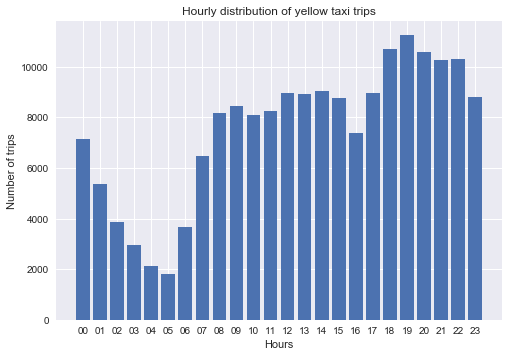

In [252]:
figure1()

Create a visualization that shows the average distance traveled per month (regardless of year - so group by each month) for both taxis and Ubers combined. Include the 90% confidence interval around the mean in the visualization.


In [270]:
def figure2():
    import scipy.stats as st
    query1 = '''
    select 
    t_0.month as month,
    sum(t_0.total_trips) as total_trips,
    sum(t_0.distance) as distance

    from 

    (select 
    strftime ('%m',pickup_time) as month,
    count(*) as	total_trips,
    sum(distance) as distance

    from 
    yellow_taxi

    where 
    pickup_time between '2009-01-01' and '2015-06-30'

    group by 
    strftime ('%m',pickup_time)

    union 

    select 
    strftime ('%m',pickup_time) as month,
    count(*) as	total_trips,
    sum(distance) as distance

    from 
    Uber

    where 
    pickup_time between '2009-01-01' and '2015-06-30'

    group by 
    strftime ('%m',pickup_time)
    )t_0
    
    group by 
    t_0.month
    '''
    df = pd.DataFrame(data = engine.execute(query1).fetchall(),columns = ['month','total_trips','distance'])
    df['avg_distance'] = df['distance']/df['total_trips']
    low_CI_bound, high_CI_bound = st.t.interval(0.90, len(df['avg_distance']) - 1,
                                            loc= df['avg_distance'].mean(),
                                            scale= st.sem(df['avg_distance']))
    plt.bar(df['month'],df['avg_distance'])
    plt.plot(df['month'], [low_CI_bound]*12,'--',label = 'low_CI_bound',color = 'purple')
    plt.plot(df['month'], [high_CI_bound]*12,'--',label = 'high_CI_bound',color = 'blue')
    plt.plot(df['month'],[df['avg_distance'].mean()]*12,color = 'r',label = 'Mean Value')

    
    plt.title('Monthly distribution of average distance for hired taxi')
    plt.xlabel('Month')
    plt.ylabel('Average Distance')
    legend = plt.legend(frameon = 1)
    frame = legend.get_frame()
    frame.set_color('white')
    plt.show()

[sqlalchemy] 
    select 
    t_0.month as month,
    sum(t_0.total_trips) as total_trips,
    sum(t_0.distance) as distance

    from 

    (select 
    strftime ('%m',pickup_time) as month,
    count(*) as	total_trips,
    sum(distance) as distance

    from 
    yellow_taxi

    where 
    pickup_time between '2009-01-01' and '2015-06-30'

    group by 
    strftime ('%m',pickup_time)

    union 

    select 
    strftime ('%m',pickup_time) as month,
    count(*) as	total_trips,
    sum(distance) as distance

    from 
    Uber

    where 
    pickup_time between '2009-01-01' and '2015-06-30'

    group by 
    strftime ('%m',pickup_time)
    )t_0
    
    group by 
    t_0.month
    
[sqlalchemy] [raw sql] ()


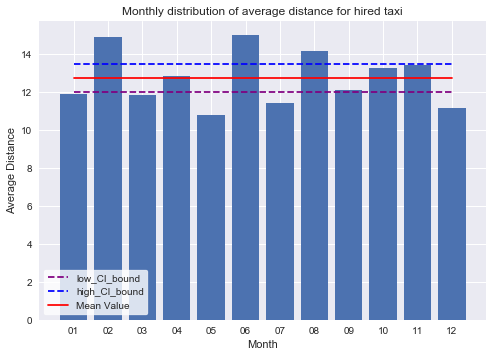

In [271]:
figure2()

Define three lat/long coordinate boxes around the three major New York airports: LGA, JFK, and EWR (you can use bboxfinder to help). Create a visualization that compares what day of the week was most popular for drop offs for each airport.


In [273]:
## LGA: -73.890736,40.764350,-73.850310,40.786514
## JFK: -73.827581,40.620071,-73.746385,40.665530
## EWR: -74.193342,40.685069,-74.166541,40.695986

In [296]:
def figure3():
    query1 = '''
    select 
    strftime ('%w',pickup_time) as day,
    dropoff_longitude,
    dropoff_latitude


    from 

    yellow_taxi

    union 

    select 
    strftime ('%w',pickup_time) as day,
    dropoff_longitude,
    dropoff_latitude


    from 

    Uber 
    '''
    airports = {'LGA':[-73.890736,40.764350,-73.850310,40.786514],
                'JFK':[-73.827581,40.620071,-73.746257,40.665530],
                'EWR':[-74.193342,40.685069,-74.166541,40.695986]
               }
    df = pd.DataFrame(data = engine.execute(query1).fetchall(),columns = ['day','dropoff_longitude','dropoff_latitude'])
    for airport in airports.keys():
        location = airports[airport]
        df_temp = df.loc[(df['dropoff_longitude']>=location[0])&(df['dropoff_longitude']<=location[2])
                         &(df['dropoff_latitude']>=location[1])&(df['dropoff_latitude']<=location[3])]
        
        df_temp = df_temp.groupby(['day']).size().reset_index().rename(columns = {0:'count'})
        
        plt.bar(df_temp['day'], df_temp['count'])
        x_ticks = ['Sun','Mon','Tue','Wed','Thur','Fri','Sat']
        plt.xticks(np.arange(7),x_ticks)
        plt.title('Daily distribution of drop offs amount near {}'.format(airport))
        plt.xlabel('Day of the week')
        plt.ylabel('Number of drop offs')
        plt.show()

[sqlalchemy] 
    select 
    strftime ('%w',pickup_time) as day,
    dropoff_longitude,
    dropoff_latitude


    from 

    yellow_taxi

    union 

    select 
    strftime ('%w',pickup_time) as day,
    dropoff_longitude,
    dropoff_latitude


    from 

    Uber 
    
[sqlalchemy] [raw sql] ()


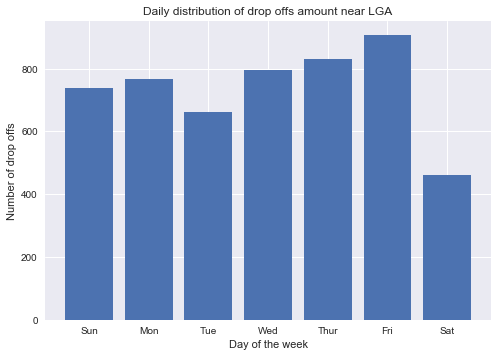

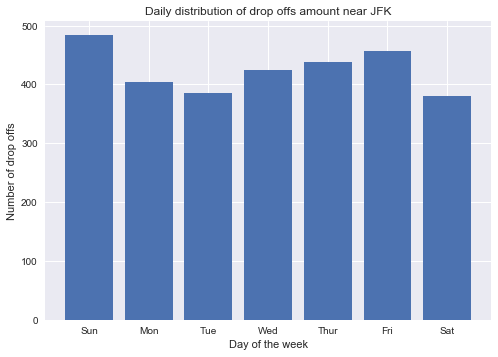

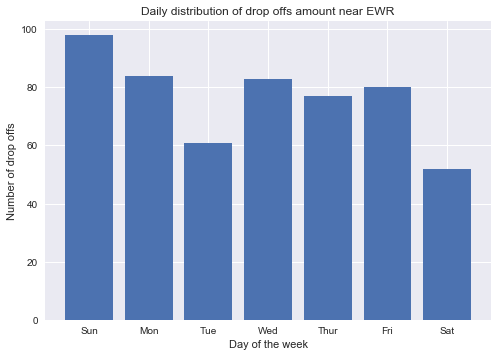

In [297]:
figure3()

Thus, the most popular day for drop offs in LGA, JFK and EWR is Friday, Sunday and Sunday respectively

Create a heatmap of all hired trips over a map of the area. Consider using KeplerGL or another library that helps generate geospatial visualizations.


In [42]:
def createZoneTable(zone_factor,westlimit, southlimit, eastlimit, northlimit):
    zone_table = list()
    hor = np.linspace(start = westlimit, stop = eastlimit, num=zone_factor+1)
    ver = np.linspace(start = southlimit, stop = northlimit, num=zone_factor+1)
    for i in range(zone_factor*zone_factor):
        zone_number = "%02d" % i 
        bottomleft_co = [hor[i%zone_factor],ver[i//zone_factor]]
        bottomright_co = [hor[(i%zone_factor+1)],ver[i//zone_factor]]
        upperleft_co = [hor[i%zone_factor],ver[i//zone_factor+1]]
        upperright_co = [hor[i%zone_factor+1],ver[i//zone_factor+1]]
        zone_table.append((zone_number,[bottomleft_co,bottomright_co,upperright_co,upperleft_co,bottomleft_co]))
    return zone_table

In [43]:
def createGeoJsonObject(zone_table):
    zone_data_dict = dict()
    zone_data_dict['type'] = 'FeatureCollection'
    zone_data_dict_features = list()
    zone_data_dict['features'] = zone_data_dict_features
    
    for index in range(len(zone_table)):
        coordinates_list = [zone_table[index][1]]
        zone_id = zone_table[index][0]        
        content = {
            'geometry': {"coordinates": coordinates_list,'type':'Polygon'},
            "properties":{'zone_id':zone_id},
            'type':'Feature'
        }
        zone_data_dict_features.append(content)
    
    return zone_data_dict

In [44]:
def get_zone(lon,lat,zone_table):
    for i in range(len(zone_table)):
        zone = None
        item = zone_table[i]
        hormin = item[1][0][0]
        vermin = item[1][0][1]
        hormax = item[1][2][0]
        vermax = item[1][2][1]
        if np.logical_and(lon<=hormax,lon>=hormin) & np.logical_and(lat<=vermax,lat>=vermin):
            zone = item[0]
            break
    return zone

In [45]:
def figure4():
    query1 = '''
    select 
    pickup_longitude,
    pickup_latitude,
    dropoff_longitude,
    dropoff_latitude


    from 

    yellow_taxi

    union 

    select 
    pickup_longitude,
    pickup_latitude,
    dropoff_longitude,
    dropoff_latitude

    from 

    Uber 
    '''
 
    df = pd.DataFrame(data = engine.execute(query1).fetchall(),columns = ['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude'])
    df = df.loc[(df['pickup_longitude']>= -74.242330)&(df['pickup_longitude']<= -73.717047)&(df['pickup_latitude']>=40.560445)&(df['pickup_latitude']<=40.908524)&
                (df['dropoff_longitude']>= -74.242330)&(df['dropoff_longitude']<= -73.717047)&(df['dropoff_latitude']>=40.560445)&(df['dropoff_latitude']<=40.908524)
               ]
    
    
    zonetable = createZoneTable(20,df['pickup_longitude'].min(), df['pickup_latitude'].min(), 
                            df['pickup_longitude'].max(), df['pickup_latitude'].max())
    df['pickup_zone'] = df.apply(lambda x: get_zone(x['pickup_longitude'],x['pickup_latitude'],zonetable),axis=1)
    
    pickup_cnt = df.groupby(['pickup_zone']).size().to_frame().rename(columns = {0:'pickup_count'}).reset_index()
    
    import folium
    #Center the map at Times Square
    m = folium.Map(location = [40.7589,-73.9851],zoom_start=12,titles = 'Heatmap for pickups')
    m.choropleth(geo_data = createGeoJsonObject(zonetable) , data = pickup_cnt, 
                 columns=['pickup_zone', 'pickup_count'],key_on="properties.zone_id",
                 fill_color='YlGn', fill_opacity=0.7, line_opacity=0.8,
                 legend_name='Distribution of pickups')
    folium.LayerControl().add_to(m)
    return m
    
    

In [46]:
figure4()

[sqlalchemy] 
    select 
    pickup_longitude,
    pickup_latitude,
    dropoff_longitude,
    dropoff_latitude


    from 

    yellow_taxi

    union 

    select 
    pickup_longitude,
    pickup_latitude,
    dropoff_longitude,
    dropoff_latitude

    from 

    Uber 
    
[sqlalchemy] [raw sql] ()


/Users/yuanshuqing/.local/lib/python3.6/site-packages/folium/folium.py:413: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


Create a scatter plot that compares tip amount versus distance for Yellow Taxi rides. You may remove any outliers how you see fit.


In [23]:
def estimate_gaussian(dataset):

    mu = np.mean(dataset) # moyenne cf mu
    sigma = np.std(dataset) # écart_type/standard deviation
    limit = sigma * 1.5

    min_threshold = mu - limit
    max_threshold = mu + limit

    return mu, sigma, min_threshold, max_threshold

In [24]:
def figure5():
    query1 = '''
    select 
    tip,
    distance

    from 

    yellow_taxi
    '''
    
    df = pd.DataFrame(data = engine.execute(query1).fetchall(),columns = ['tip','distance'])
    df = df.loc[df['distance']!=0]
    df['ratio'] = df['tip']/df['distance']
    
    mu, sigma, min_threshold, max_threshold = estimate_gaussian(df['ratio'].values)

    condition1 = (df['ratio'] < min_threshold)
    condition2 = (df['ratio'] > max_threshold)
    
    outliers1 = np.extract(condition1, df['ratio'])
    outliers2 = np.extract(condition2, df['ratio'])

    outliers = np.concatenate((outliers1, outliers2), axis=0)
    df_red = df[df['ratio'].isin(outliers)]
    df = df[~df['ratio'].isin(outliers)]
    
    plt.scatter(df['distance'],df['tip'],label = 'normal',zorder = 0)
    plt.scatter(df_red['distance'],df_red['tip'], c ='brown',label = 'outliers',zorder = 1)
    plt.plot(df['distance'], np.poly1d(np.polyfit(df['distance'], df['tip'], 1))(df['distance']),color = 'purple',label = 'fitted_values')
    
    plt.title('Relationship between tips and distance')
    plt.xlabel('Distance')
    plt.ylabel('Tips')
    plt.legend()
    plt.show()
    

[sqlalchemy] 
    select 
    tip,
    distance

    from 

    yellow_taxi
    
[sqlalchemy] [raw sql] ()


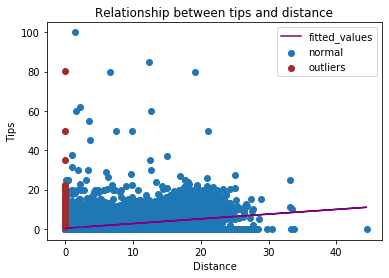

In [25]:
figure5()

Create another scatter plot that compares tip amount versus precipitation amount for Yellow Taxi rides. You may remove any outliers how you see fit.

In [26]:
def figure6():
    query1 = '''
    select 
    t_1.date as date,
    t_1.tip as tip,
    t_2.precipitation as precipitation

    from 

    (select

    strftime ('%Y-%m-%d',pickup_time) as date,
    avg(tip) as tip 

    from 
    yellow_taxi

    group by 
    strftime ('%Y-%m-%d',pickup_time) 
    )t_1

    left join 

    (select 
    strftime ('%Y-%m-%d',date) as date,
    precipitation    

    from 
    weather_daily
    )t_2

    on 
    t_1.date = t_2.date
    '''
    
    df = pd.DataFrame(data = engine.execute(query1).fetchall(),columns = ['hourly_date','tip','precipitation'])

    df['ratio'] = df['tip']/(df['precipitation'].apply(lambda x: x+0.0000001 if x==0 else x))
    
    mu, sigma, min_threshold, max_threshold = estimate_gaussian(df['ratio'].values)

    condition1 = (df['ratio'] < min_threshold)
    condition2 = (df['ratio'] > max_threshold)
    
    outliers1 = np.extract(condition1, df['ratio'])
    outliers2 = np.extract(condition2, df['ratio'])

    outliers = np.concatenate((outliers1, outliers2), axis=0)
    df_red = df[df['ratio'].isin(outliers)]
    df = df[~df['ratio'].isin(outliers)]
    
    plt.scatter(df['precipitation'],df['tip'],label = 'normal',zorder = 0)
    plt.scatter(df_red['precipitation'],df_red['tip'], c ='brown',label = 'outliers',zorder = 1)
    #plt.plot(df['precipitation'], np.poly1d(np.polyfit(df['precipitation'], df['tip'], 1))(df['precipitation']),color = 'purple',label = 'fitted_values')
    
    plt.title('Relationship between tips and precipitation')
    plt.xlabel('Precipitation')
    plt.ylabel('Tips')
    plt.legend()
    plt.show()
    

[sqlalchemy] 
    select 
    t_1.date as date,
    t_1.tip as tip,
    t_2.precipitation as precipitation

    from 

    (select

    strftime ('%Y-%m-%d',pickup_time) as date,
    avg(tip) as tip 

    from 
    yellow_taxi

    group by 
    strftime ('%Y-%m-%d',pickup_time) 
    )t_1

    left join 

    (select 
    strftime ('%Y-%m-%d',date) as date,
    precipitation    

    from 
    weather_daily
    )t_2

    on 
    t_1.date = t_2.date
    
[sqlalchemy] [raw sql] ()


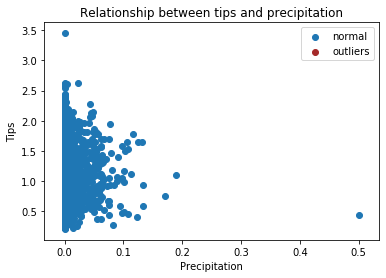

In [27]:
figure6()
# no particular trend has been detected

Come up with 3 questions on your own that can be answered based on the data in the 4 tables. Create at least one visualization to answer each question. At least one visualization should require data from at least 3 tables.


<li> 1.The trend of yellow taxi' tips from 2009-2015

In [37]:
def figure7_1():
    query1 = '''
    select 
    strftime ('%m',pickup_time) as date,
    avg(tip) as tip

    from 

    yellow_taxi

    group by 

    strftime ('%m',pickup_time) 
    '''
    
    df = pd.DataFrame(data = engine.execute(query1).fetchall(),columns = ['month','tip'])

    plt.plot(df['month'],df['tip'])
     
    plt.title('Trend of tips')
    plt.xlabel('Month')
    plt.ylabel('Tips')
    plt.show()
    

[sqlalchemy] 
    select 
    strftime ('%m',pickup_time) as date,
    avg(tip) as tip

    from 

    yellow_taxi

    group by 

    strftime ('%m',pickup_time) 
    
[sqlalchemy] [raw sql] ()


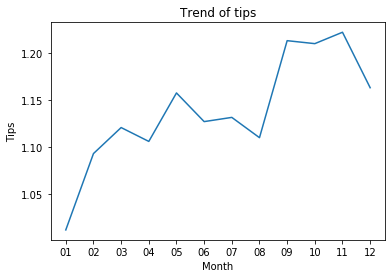

In [38]:
figure7_1()

2.Is uber faster than yellow taxi in 2015?